In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import zarr
import re
import numpy as np
import xml.etree.ElementTree as ET
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from scipy.spatial import KDTree
from collections import defaultdict, deque


In [5]:
from pathlib import Path

from skimage import exposure
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
from skimage.filters import threshold_otsu

In [16]:
# ----- File Paths -----
# base_path per OS
# macOS
base_path = Path("/Volumes/tnegrell/group/siegegrp/ThNe/development_retina/")
# Ubuntu
# base_path = Path("/mnt/gdrive/ThNe/development_retina/")
# Windows
# base_path = Path("Z:/siegegrp/ThNe/development_retina/")
#debian
# base_path = Path("/run/user/1009/gvfs/smb-share:server=fs.ista.ac.at,share=drives/tnegrell/group/siegegrp/ThNe/development_retina/")

xml_folder = Path("blood/")
file_name = Path("P15/F/L/blood_Age_P15_Sex_F_Side_L_Animal_1")

file_path = base_path / xml_folder / file_name

tif_path = file_path.with_suffix(".tif")


In [ ]:
# img = tiff.imread(tif_path)


In [18]:
img.shape

(68, 7486, 7480)

In [59]:
blood_img = img[4:40]

In [60]:
blood_img.shape

(36, 7486, 7480)

In [112]:
blood_sample = blood_img[:, 5000:6000,2000:3000]

In [90]:
blood_sample.shape

(36, 1000, 1000)

In [91]:
binary.shape

(36, 1000, 1000)

In [95]:
import numpy as np

# Assuming:
# - `tile_clahe` is your processed raw image after equalize_adapthist
# - `binary` is the thresholded vessel mask

np.save("../data/raw_image.npy", blood_sample)
np.save("../data/vessels_binary.npy", binary)


In [98]:
np.save("../data/tile_clahe.npy", tile_clahe[27]
)


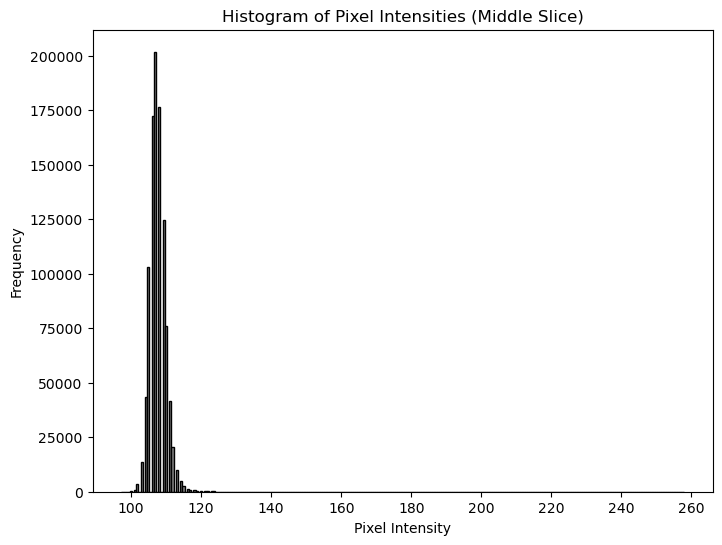

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming blood_sample is your raw 3D image loaded as a NumPy array

# Select the middle slice along the first dimension
slice_idx = blood_sample.shape[0] // 2
slice_image = blood_sample[27]

# Plot the histogram of the pixel intensities.
plt.figure(figsize=(8, 6))
plt.hist(slice_image.ravel(), bins=256, color='gray', edgecolor='black')
plt.title("Histogram of Pixel Intensities (Middle Slice)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


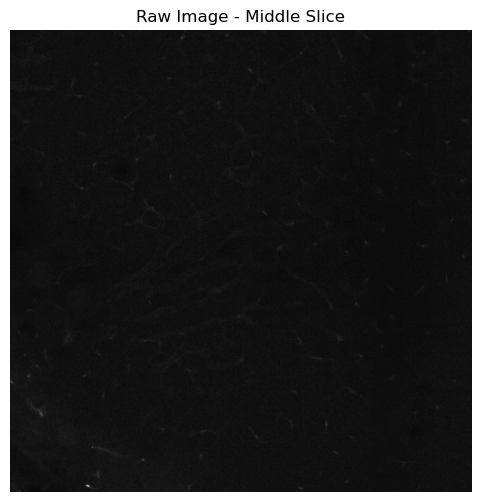

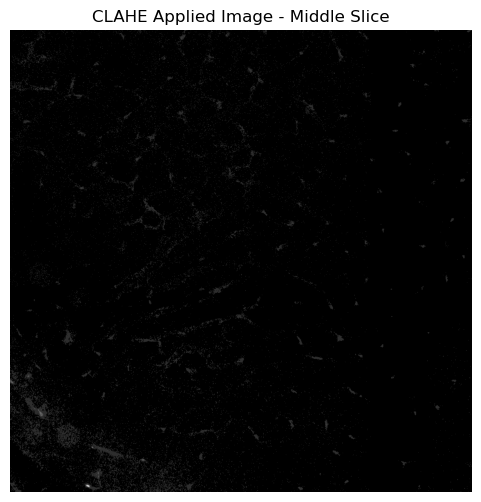

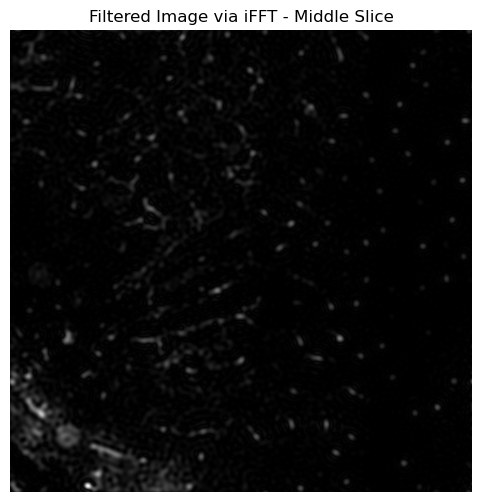

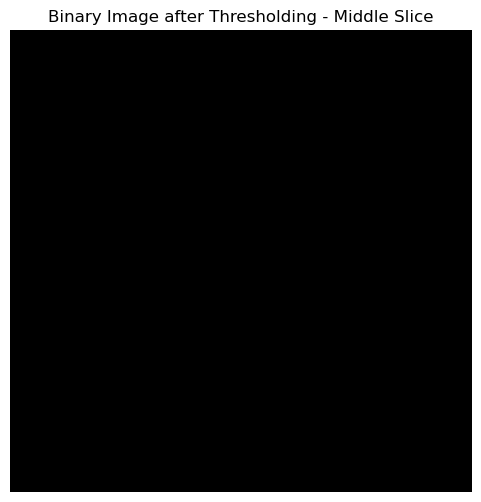

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters
from numpy.fft import fftn, ifftn, fftshift, ifftshift

# --- Ensure blood_sample is your raw 3D image ---
# For example:
# blood_sample = your_loading_function("path/to/your/3D_image_file")

# We'll use the middle slice from the first dimension for visualization.
slice_idx = blood_sample.shape[0] // 2
slice_idx = 27
# -----------------------------
# Step 0: Visualize the raw image middle slice
plt.figure(figsize=(6, 6))
plt.imshow(blood_sample[slice_idx], cmap='gray')
plt.title("Raw Image - Middle Slice")
plt.axis('off')
plt.show()

# -----------------------------
# Step 1: Apply CLAHE (Contrast-Limited Adaptive Histogram Equalization)
tile_clahe = exposure.equalize_adapthist(blood_sample, clip_limit=0.01)

plt.figure(figsize=(6, 6))
plt.imshow(tile_clahe[slice_idx], cmap='gray')
plt.title("CLAHE Applied Image - Middle Slice")
plt.axis('off')
plt.show()

# -----------------------------
# Step 2: Fourier Transform of the CLAHE image
f_img = fftn(tile_clahe)
f_img_shifted = fftshift(f_img)

# -----------------------------
# Step 3: Create a low-pass filter mask (to keep vessel-scale features)
shape = tile_clahe.shape
center = np.array(shape) // 2
radius = 70  # adjust this value based on the spatial frequency of the noise/features

# Build a 3D grid and compute the Euclidean distance from the center for each voxel
Z, Y, X = np.ogrid[:shape[0], :shape[1], :shape[2]]
dist_from_center = np.sqrt((Z - center[0])**2 + (Y - center[1])**2 + (X - center[2])**2)
mask = dist_from_center <= radius

# -----------------------------
# Step 4: Apply the mask and perform inverse FFT to get the filtered image
f_img_filtered = f_img_shifted * mask
f_ishift = ifftshift(f_img_filtered)
img_filtered = np.abs(ifftn(f_ishift))

plt.figure(figsize=(6, 6))
plt.imshow(img_filtered[slice_idx], cmap='gray')
plt.title("Filtered Image via iFFT - Middle Slice")
plt.axis('off')
plt.show()

# -----------------------------
# Step 5: Threshold the filtered image using Otsu's method
threshold = filters.threshold_otsu(img_filtered)
binary = img_filtered > threshold

plt.figure(figsize=(6, 6))
plt.imshow(binary[slice_idx], cmap='gray')
plt.title("Binary Image after Thresholding - Middle Slice")
plt.axis('off')
plt.show()


In [118]:
binary.shape

(36, 1000, 1000)

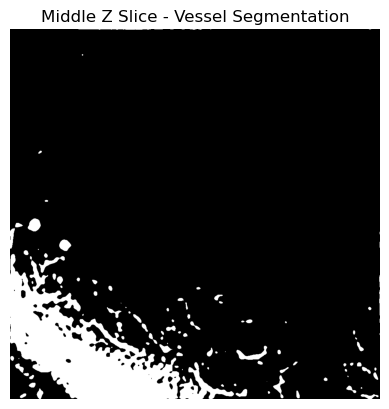

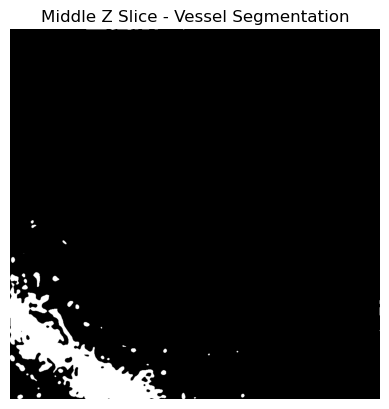

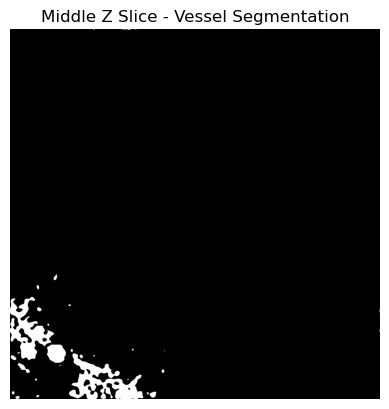

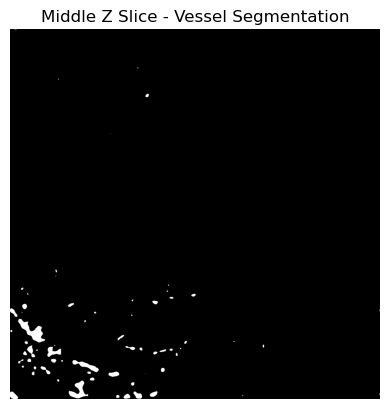

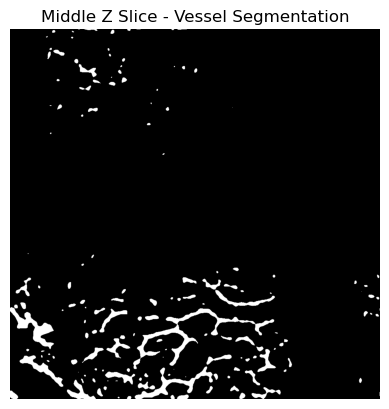

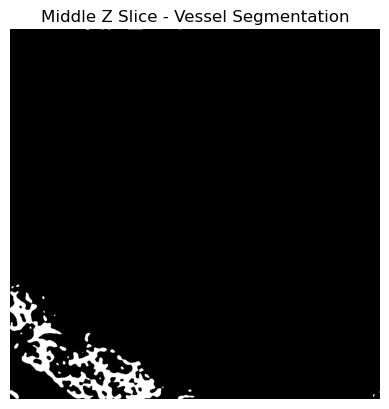

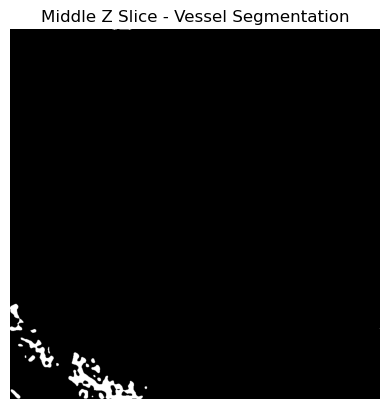

In [119]:
# Visualize a slice
for i in [22, 24, 26, 28, 30, 32, 34]:

    plt.imshow(binary[i], cmap='gray')
    plt.title('Middle Z Slice - Vessel Segmentation')
    plt.axis('off')
    plt.show()

In [108]:
img_filtered.shape

(36, 1000, 1000)

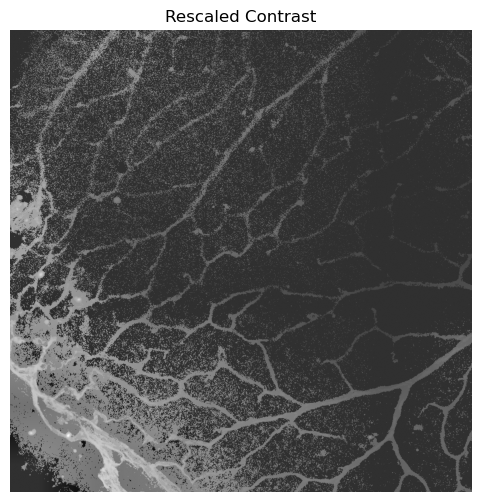

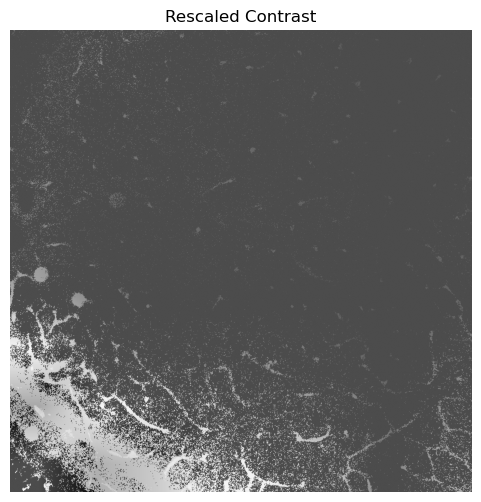

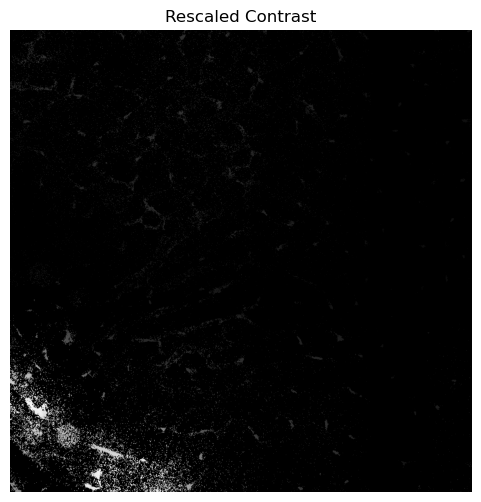

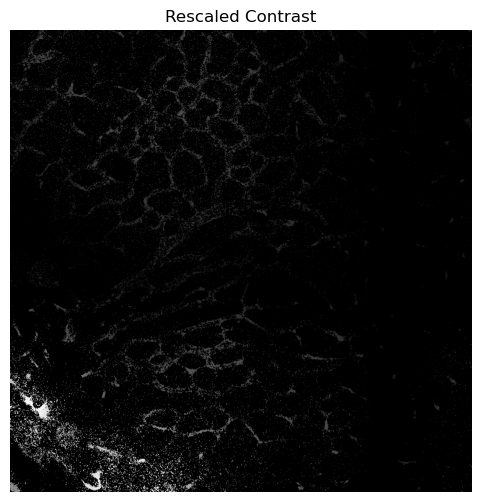

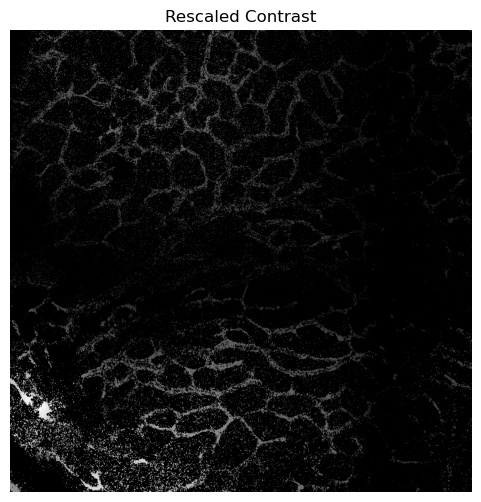

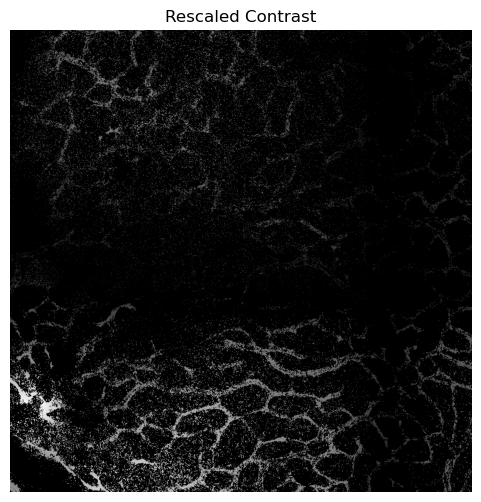

In [ ]:
blood_sample_clahe = exposure.equalize_adapthist(blood_sample, clip_limit=0.3)
blood_sample_rescaled = exposure.rescale_intensity(blood_sample, out_range=(0, 1))

for i in [16, 22, 27, 28, 29, 30]:
    tile = blood_sample_rescaled[i]
    plt.figure(figsize=(6, 6))
    plt.imshow(tile, cmap='gray')
    plt.title("Rescaled Contrast")
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters

# --- Assuming blood_sample is your raw 3D image ---
# For example, if blood_sample is not already in [0, 1], you can rescale its intensities:
# blood_sample_rescaled = exposure.rescale_intensity(blood_sample, out_range=(0, 1))

# --- Frangi Vesselness Filter ---
# The Frangi filter analyzes the Hessian matrix at multiple scales to enhance tubular structures.
# scale_range sets the minimum and maximum scales to analyze, while scale_step is the increment.
# Set black_ridges to True if vessels are darker than the background;
# here, False is used if vessels are bright on a dark background.

# alpha
# Frangi correction constant that adjusts the filter’s sensitivity to deviation from a plate-like structure.
# beta
# Frangi correction constant that adjusts the filter’s sensitivity to deviation from a blob-like structure.
# gamma
# Frangi correction constant that adjusts the filter’s sensitivity to areas of high variance/texture/structure. 

# The default, None, uses half of the maximum Hessian norm.
vesselness = filters.frangi(blood_sample[10:], sigmas=range(1, 100, 2), 
                       scale_range=None, 
                       scale_step=None, 
                       alpha=0.5,
                         beta=0.5, 
                         gamma=None, 
                         black_ridges=False, 
                         mode='reflect', 
                         cval=0)
# --- Visualization ---
# We'll display a middle slice from the 3D volume for visualization.
slice_idx = vesselness.shape[0] // 2

plt.figure(figsize=(8, 8))
plt.imshow(vesselness[slice_idx], cmap='gray')
plt.title("Frangi Vessel Enhancement (Middle Slice)")
plt.axis('off')
plt.show()


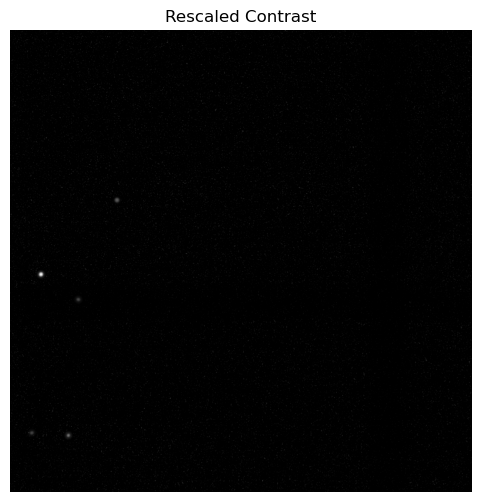

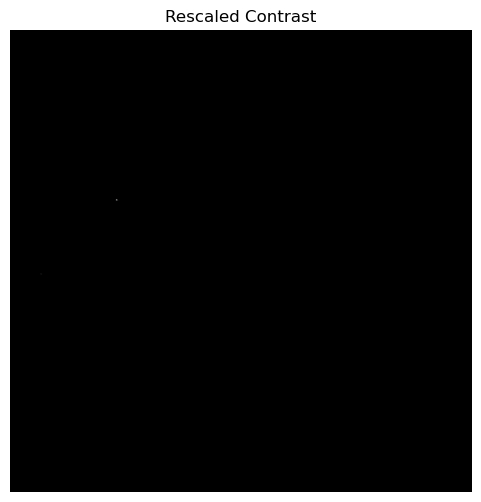

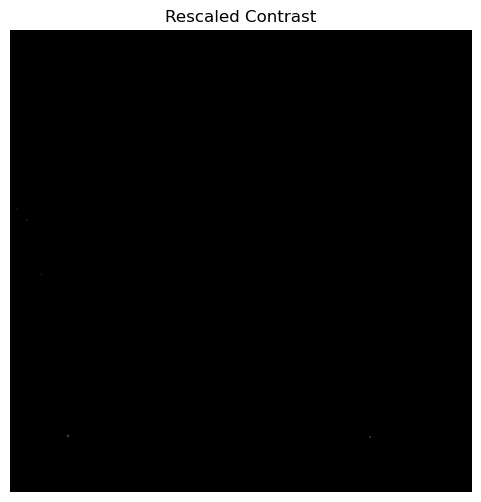

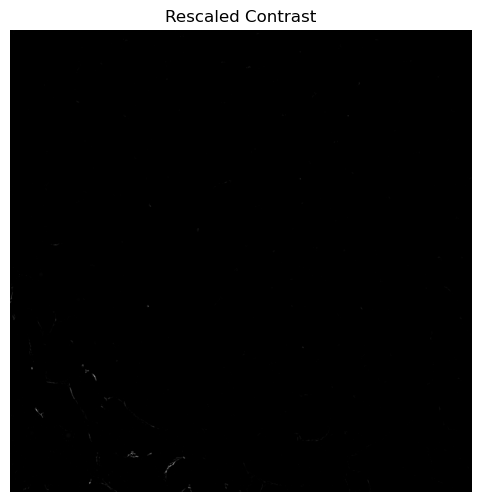

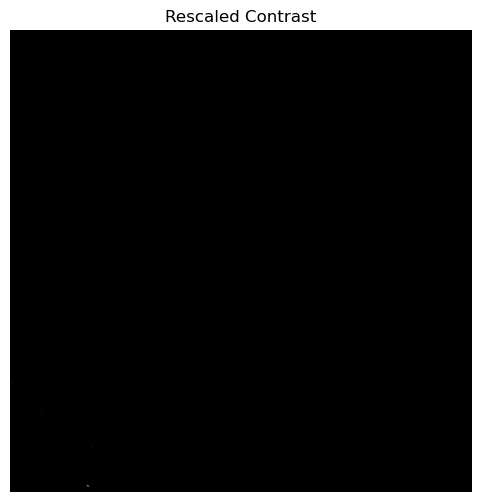

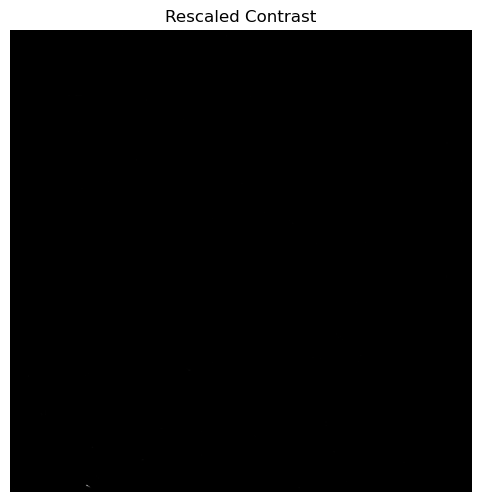

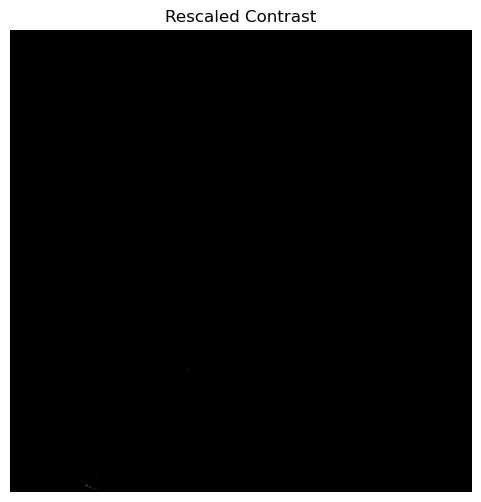

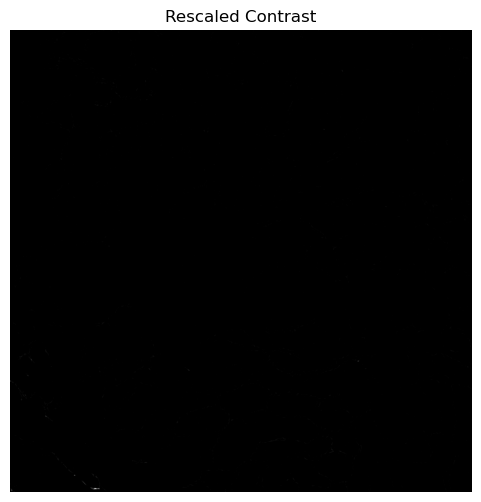

In [130]:
# blood_sample_clahe = exposure.equalize_adapthist(blood_sample, clip_limit=0.3)

for i in [4, 10, 16, 22, 27, 28, 29, 30]:
    tile = vesselness[i]
    plt.figure(figsize=(6, 6))
    plt.imshow(tile, cmap='gray')
    plt.title("Rescaled Contrast")
    plt.axis('off')
    plt.show()

In [ ]:
with tiff.TiffFile(tif_path) as tif:
    # Check how many slices (Z-dimension) the image has
    num_slices = len(tif.pages)
    print("Number of Z-slices:", num_slices)
    
    # Load a single slice (e.g., middle slice)
    z_index = num_slices // 2  # or choose another index
    single_slice = tif.pages[z_index].asarray()

# Now you can display it or process it
plt.imshow(single_slice, cmap='gray')
plt.title(f"Z-slice {z_index}")
plt.show()